# Arabic Text Cleaning

I will perform text cleaning on the Arabic_Offensive_Comment_Detection dataset from HuggingFace, which is a multi-platform dataset designed for detecting offensive language in Arabic news comments.

سأقوم بتنظيف النصوص على مجموعة بيانات لتعليقات الأخبار العربية متعددة المنصات لاكتشاف اللغة الهجومية.
تم الحصول على هذه البيانات من HuggingFace.

## Import required libraries

In [1]:
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re

import pandas as pd
import numpy as np


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load and read the dataset from HuggingFace

In [2]:
df = pd.read_parquet("hf://datasets/asas-ai/Arabic_Offensive_Comment_Detection/data/train-00000-of-00001-6b8f4582b379a401.parquet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Explore the dataset

**قمت بطباعة اول خمس اسطر من مجموعة البيانات للاطلاع عليها**

In [3]:
df.head()

,Id,Platform,Comment,Majority_Label,Agreement,NumOfJudgementUsed,Total_Judgement,Vulgar:V/HateSpeech:HS/None:-
0,1,Twitter,@User.IDX في فترة الصغر والمراهقة يكون من الصع...,Non-Offensive,100.0,3,3,-
1,2,Facebook,"""ردا على معظم الردود .. أحب اوضحلكم ان عمليات ...",Non-Offensive,100.0,3,4,-
2,3,Twitter,@User.IDX يجب ان تذكروا ان لكل سنة ثيم للحفل و...,Non-Offensive,100.0,3,5,-
3,4,YouTube,بتعمل حلقة صغيرة عشان عندي امتحان بكرة ومتضيعل...,Non-Offensive,100.0,3,3,-
4,5,YouTube,على طاري السطحيه مدري ليه تذكرت فيحان,Non-Offensive,100.0,3,3,-


**قمت بطباعة المعلومات الاساسية لمجموعة البيانات كنوع البيانات لكل عمود وعدد الصفوف والذي يظهر انه يساوي 4000 صف وعدد الاعمدة  يساوي 8 اعمدة كما يتضح انه لايوجد بيانات فارغه**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Id                             4000 non-null   int64  
 1   Platform                       4000 non-null   object 
 2   Comment                        4000 non-null   object 
 3   Majority_Label                 4000 non-null   object 
 4   Agreement                      4000 non-null   float64
 5   NumOfJudgementUsed             4000 non-null   int64  
 6   Total_Judgement                4000 non-null   int64  
 7   Vulgar:V/HateSpeech:HS/None:-  4000 non-null   object 
dtypes: float64(1), int64(3), object(4)
memory usage: 250.1+ KB


**هنا قمت بحذف الاعمدة الغير مفيدة و التي لا حاجة لها**

In [5]:
df.columns

Index(['Id', 'Platform', 'Comment', 'Majority_Label', 'Agreement',
       'NumOfJudgementUsed', 'Total_Judgement',
       'Vulgar:V/HateSpeech:HS/None:-'],
      dtype='object')

In [6]:
df = df.drop(['Id', 'Platform', 'Agreement', 'NumOfJudgementUsed', 'Total_Judgement','Vulgar:V/HateSpeech:HS/None:-'], axis=1)

**هنا ساقوم بالاطلاع على توزيع البيانات في العمود الذي يحتوي على تصنيف التعليقات كمهينة او غير مهينة**

In [7]:
df['Majority_Label'].value_counts()

,count
Majority_Label,
Non-Offensive,3325
Offensive,675


In [8]:
df['Majority_Label'] = df['Majority_Label'].replace({'Non-Offensive': 0, 'Offensive': 1})
print(df['Majority_Label'].value_counts())

Majority_Label
0    3325
1     675
Name: count, dtype: int64


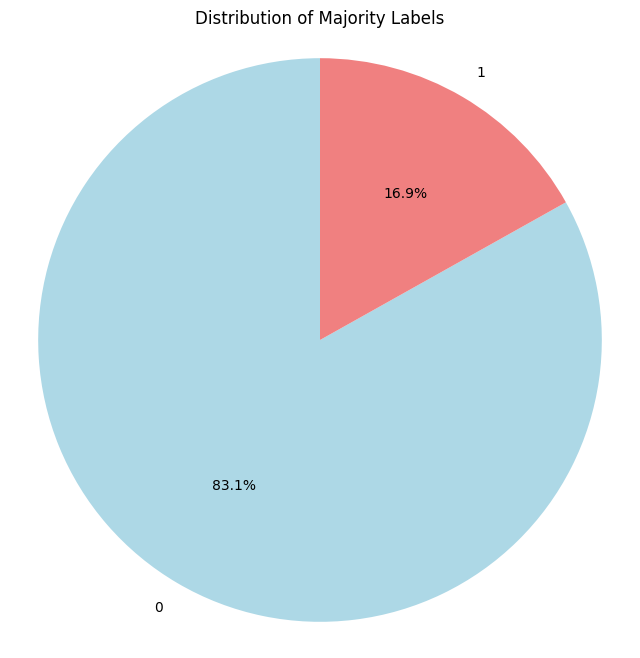

In [9]:
import matplotlib.pyplot as plt

# Count the occurrences of each label
label_counts = df['Majority_Label'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.axis('equal')
plt.title('Distribution of Majority Labels')
plt.show()



**توزيع عمود Majority_Label يشير إلى ما يلي**

التعليقات غير المهينة 0: يوجد 3325 حالة (الفئة الأكبر)

التعليقات المهينة 1: يوجد 675 حالة (الفئة الأقل)

مجموعة البيانات غير متوازنة بشكل كبير، حيث تمثل التعليقات غير المهينة حوالي 83% (3325 من إجمالي 4000)، بينما تمثل لتعليقات المهينة حوالي 17%.
هذا الاختلال قد يؤثر على أداء نماذج التعلم الآلي، خصوصًا النماذج التي تكون حساسة لتوزيعات الفئات.




**هنا سألقي نظرة على النصوص الموجودة في عمود النص**

In [11]:
for _ in df.Comment[100:200]:
    print()
    print(_)


@User.IDX من اجمل واروع المسلسلات التي رأيتها 

بعيد المشهد الاخير اكثر من مره 

الإضاءة بالاستديو ابو كلب ياشنب .. مسوي لبناني؟ 

@User.IDX لا يلمع أحد لمنسوبي داعش الارهابي الا ارهابي مثله تبا لكم 

ولسه بتسأل ليه البلاد حيطه مالت ،، مابقاش فيه أمل لما قولنا أمل ماتت ، قتلنا طموحنا لما قدمولنا نعشو كنا معكم من اعماق ال.أنت هارشو 

@User.IDX اكيد في شي لا يسكتو حتي يعرفو السبب 

 <url> ترا هذول مايمثلون السعودية عمر السوريين ولا غيرهم ماكانو ذليلين بالعكس ما ثارو الا انهم شريفين واصيلين مايرضون الظلم 

الحلقة هاي لازم تترجم بجد مفيدة 

ملاحظة صغيرة فقط : الآن الناس أصبحت أكثر ثقافة ووعي ، ويعلمون أن أصل الوحدة إسلامية وليس عربية . طالباتي الهنديات والروسيات في المدرسة يقولون لي معلمتي أصل الوحدة على الارض وبين الشعوب وحدة إسلامية وليست وحدة عروبة. ملاحظة أخرى أكثر غرابة أن عمر طالباتي 12 سنة فقط وعندهم هذا الوعي !!! 

هاذي لبنان أقسى من قلوبهم مافيش بلد عديمة الإنسانية جيرانكم الزفت ومعاملة عنصرية لي هالدرجه سبحان الله بكرة لما يجيكم الدور من إسرائيل مش حتلقو جار أكرم من سوريا 

هذا 

**النصوص بلا شك تحتاج لتنظيف هنالك الكثير من الارقام واسماء الحاسابات المكتوبة باللغة الانجليزية والكثير من الايموجي والنقاط التي سنقوم بحذفها جميعا**

## Cleaning and preprocessing the dataset

**هنا سأقوم بتغيير اسماء الاعمدة**

In [12]:
df = df.rename(columns={'Majority_Label': 'labels', 'Comment': 'text'})

**To clean the arabic text I will do the fellowing:** **لتنظيف النصوص العربية، سأقوم بالخطوات التالية**

1. Removing non-Arabic characters:
إزالة الأحرف غير العربية
   - `re.sub(r'[^\u0600-\u06FF\s]', ' ', text)`:
   
    This line uses regular expressions to replace any characters that are not Arabic letters or spaces with a space.

    هذا السطر يستخدم التعبيرات النمطية لاستبدال أي أحرف غير الحروف العربية أو المسافات بمسافة.


2. Converting to lowercase:تحويل النص إلى أحرف صغيرة
   - `p_text=p_text.lower()`: This line converts the text to lowercase.
   هذا السطر يحول النص إلى أحرف صغيرة



3. Tokenization: تجزئة النص إلى كلمات
    - `p_text=p_text.split()`: This line splits the text into a list of words.

    هذا السطر يقسم النص إلى قائمة من الكلمات.


4. Removing stop words: إزالة كلمات التوقف
   - `[port_stem.stem(word)for word in p_text if not word in stopwords.words('arabic')]`: This line iterates over the words in the text and removes any stop words (common words that don't carry much meaning). It uses the `stopwords.words('arabic')` function from the NLTK library to get a list of Arabic stop words.

      هذا السطر يقوم بحذف الكلمات التي تتكرر في النصوص وليس لها معنى مثل من،في،نحن


5. Stemming:
    - `port_stem.stem(word)`: This line uses the Porter stemmer to reduce words to their root form. This helps in grouping similar words together.

    هذه السطر يستخدم خوارزمية جذر او أساسها الكلمات لتحويل الكلمات إلى جذرها


6. Joining the words back into a string: إعادة ربط الكلمات في نص واحد  
    - `p_text=' '.join(p_text)`: This line joins the processed words back into a single string.

    هذه السطر يعيد ربط الكلمات المعالجة في نص واحد.
  

**سأقوم بقوم بإنشاء كائن من Porter Stemmer، وهي خوارزمية تستخدم لتقليص الكلمات إلى جذورها أو أساسها.**

In [13]:
port_stem=PorterStemmer()

**هنا قمت بعمل دالة والتي حين استدعئها ستقوم بجميع خطوات التنظيف المذكورة أعلاه**

In [14]:
def processing(text):
    p_text=re.sub(r'[^\u0600-\u06FF\s]', ' ', text)
    p_text=p_text.lower()
    p_text=p_text.split()
    p_text=[port_stem.stem(word)for word in p_text if not word in stopwords.words('arabic')]
    p_text=' '.join(p_text)
    return p_text

**لتأكد من عمل الدالة سأقوم بتطبيقها على اول صف**

In [15]:
processing(df['text'][0])

'فترة الصغر والمراهقة يكون الصعب تقبل تعليقات الأصدقاء حول شعرك المجعد وهنا يأتي دور الوالدين ادخال الثقة الى نفسية طفلهما تقدم بالسن يصبح الأمر عاديا اتكلم تجربتي شخصية'

**لقد قمت بعمل جيد النص نظيف تماما**

**هنا قمت بتحويل النص الى نوع String**

In [16]:
df['text'] = df['text'].astype(str)

**هنا قمت بتطبيق الدالة على جميع النصوص**

In [17]:
df['text']=df['text'].apply(processing)

In [18]:
print(df['text'])

0       فترة الصغر والمراهقة يكون الصعب تقبل تعليقات ا...
1       ردا معظم الردود أحب اوضحلكم ان عمليات زرع الكل...
2       يجب ان تذكروا ان لكل سنة ثيم للحفل نوع الحفلات...
3       بتعمل حلقة صغيرة عشان عندي امتحان بكرة ومتضيعل...
4                       طاري السطحيه مدري ليه تذكرت فيحان
                              ...                        
3995    والله اعرف ابكي حالنا وصلنا ليه ام ابكي المواه...
3996    انا الحين ملخبط كلها البطاقه الائتمانية الحلال...
3997    متأكد ستيفن هوكينج مسلما وثبتت تجاربه نظرياته ...
3998    فكرة الدين حكم الاراهبين يطبق عليهم حكم الخوار...
3999    انااااا اللي استفدتو موت حمزه انة ساعات انت تح...
Name: text, Length: 4000, dtype: object


In [19]:
df.head()

,text,labels
0,فترة الصغر والمراهقة يكون الصعب تقبل تعليقات ا...,0
1,ردا معظم الردود أحب اوضحلكم ان عمليات زرع الكل...,0
2,يجب ان تذكروا ان لكل سنة ثيم للحفل نوع الحفلات...,0
3,بتعمل حلقة صغيرة عشان عندي امتحان بكرة ومتضيعل...,0
4,طاري السطحيه مدري ليه تذكرت فيحان,0


**بعد ما قمت بعمل تنظيف للنص سأقوم بحفظة في ملف جديد**

In [20]:
df.to_csv('arabic_comments_cleaned.csv', index=False)